**AST4310, Autumn 2020, Python version**

# Project 6b: Scattering
This project is based on work by Ida Hansen.

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib as mpl

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy import units
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats, HTML, display
from cycler import cycler
from numba import jit

quantity_support()
set_matplotlib_formats('svg')
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('legend', frameon=False)

In [3]:
from numba import jit 
from math import exp

@jit(nopython=True)
def iplus(tau, source_function, mu):
    """
    Calculates I+ for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = numpy.zeros(ndep)
    for i in range(ndep):
        i_upw = source_function[-1]
        ibot = i - len(tau)
        for j in range(-1, ibot, -1):
            expdtau = exp(-(tau[j] - tau[j - 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw
    return intensity


@jit(nopython=True)
def iminus(tau, source_function, mu):
    """
    Calculates I- for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = numpy.zeros(ndep)
    for i in range(ndep):
        i_upw = 0.
        for j in range(i):
            expdtau = exp((tau[j] - tau[j + 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw 
    return intensity

---

### Exercise 1: Pure scattering

We consider a homogeneous slab in 3D space where there is no absorption and photons only interact with the medium through scattering. This means that $\alpha_\nu^a = 0$ such that $\varepsilon_\nu = 0$.



<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
  <img style="float: right;" src="images/mfp.svg" width=50px>
    
* Use a Monte Carlo random walk calculation to show that the total path length traveled after N scatterings is $l^* \approx \sqrt{N} l$.

We advance a photon by one mean free path and scatter it in a random direction. This is done by assigning two random angles $\varphi \in [0, 2\pi)$ and $\theta \in [0,\pi)$ from uniform distributions. This Monte Carlo simulation is implemented in the function `scatter`.

In [4]:
def scatter(n_scatterings, mean_free_path):    
    phi = np.random.uniform(0, 2*np.pi, n_scatterings)
    theta = np.random.uniform(0, np.pi, n_scatterings)
    x = mean_free_path*np.sin(theta)*np.cos(phi)
    y = mean_free_path*np.sin(theta)*np.sin(phi)
    z = mean_free_path*np.cos(theta)
    
    xpos = np.cumsum(x)
    ypos = np.cumsum(y)
    zpos = np.cumsum(z)
    
    return xpos, ypos, zpos

We perfrom 100 Monte Carlo simulations, analogous to simulating 100 photons. Each photon is subject to $10^5$ scatterings. We find the mean value from all Monte Carlo simulations and compare with $l^* \approx \sqrt{N} l$.

In [5]:
N = 10**3                  #Number of scatterings
l = 7                      #Mean free path
n_MC = 10**3               #Number of Monte Carlo simulations
l_star = np.zeros(n_MC)    #Length a photon travels in each Monte Carlo simulation

for i in range(len(l_star)):
    x, y, z = scatter(N, l)
    l_star[i] = np.linalg.norm((x[-1] - x[0], y[-1] - y[0], z[-1] - z[0]))

mean_length = np.mean(l_star)
N_l = np.sqrt(N)*l
display(HTML(r"Mean value from Monte Carlo simulations: %.1f.  Approximation $l^*$: %.1f" %(mean_length, N_l)))
display(HTML(r"Relative error %.2f" %(abs(mean_length-N_l)/mean_length)))

We get a relative error around $10\%$. If we increase the number of Monte Carlo simulations (photons), this error will decrease. We plot a Monte Carlo simulation in 3D to visualise a photons path.

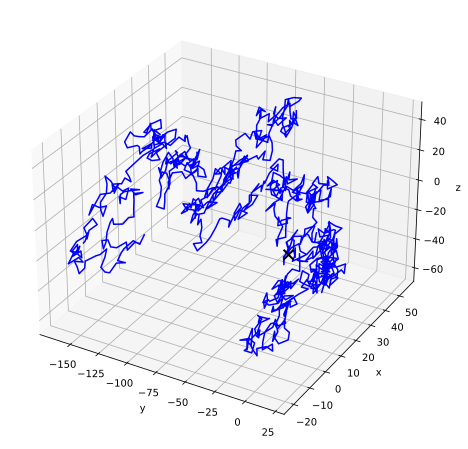

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(*scatter(10**3, 5), marker='.', ms=0.1)
ax.plot([0.], [0.], 'kx', ms=10, mew=2)
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_zlabel("z");

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
* For an optically thick slab of thickness D, the total number of scattering before the photon escape is $N \approx \tau^2$. Show this:
    1. Analytically
    2. Using a Monte Carlo simulation

*Hint: Plot the simulated values for different extinction values.* 
</div>

For a random walk, the net displacement of a photon is 
$$
\vec{R} = \vec{r}_1 + \vec{r}_2 + \dots + \vec{r}_N\,.
$$
To find the distance traveled by a typical photon, we have to find $\left \langle \vec{R}^2 \right \rangle$, because the mean displacement is zero. We find
$$
l_*^2 = \left \langle \vec{R}^2 \right \rangle = \left \langle \vec{r}_1^2 \right \rangle + \left \langle \vec{r}_2^2 \right \rangle + \left \langle \vec{r}_N^2 \right \rangle + \dots + 2\left \langle \vec{r}_1\cdot\vec{r}_2 \right \rangle + 2\left \langle \vec{r}_1\cdot\vec{r}_2 \right \rangle + \dots\,.
$$

Each term involving the square of a displacement averages to the mean square of the free path of a photon, and the cross terms vanish for isotropic scattering. Therefore,
$$
l_*^2 \approx Nl^2 \Rightarrow N \approx \frac{l_*^2}{l^2}\,.
$$
The number of scatterings required for a photon to escape the optically thick medium is determined by $l_* \approx D$. Since $l$ is the mean free path, $\tau \approx D/l$. Therefore the number of scatterings a photon has before escaping the medium is 
$$
N \approx \tau^2\,.
$$

---- 
### Exercise 2: Diffusion by scattering

A rectangular box contains a medium with extinction $\alpha^a$ and $\alpha^s$ from absorption and scattering processes respectively. At the bottom of the box, photons are emitted vertically only from specific locations. The locations where photons are emitted are given by a mask saved in the file `RoCS_array.npy`, which contains an integer array. Photons should be emitted only from locations where this array is one. When plotting, be sure to use `origin='lower'` so that the orientation is correct:

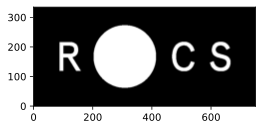

In [7]:
data = np.load("RoCS_array.npy")
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(data, origin='lower', cmap=plt.get_cmap('gist_gray'));

You can assume the physical size of each pixel is 1 m x 1 m. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

By means of a Monte Carlo simulation, study how the scattering and absorption in the medium affect the intensity measured at the top of the box (after crossing the medium). Simulate photons being emitted in pixels given by the mask above, initially all in the vertical direction. After a photon travels an optical depth of $\tau_0$, it will interact with matter and suffer one of two outcomes: be absorbed (destroyed) or be scattered. Scattered photons should be given a random new direction of travel, and then travel a new optical depth of $\tau_1$ until they have another interaction with matter. This simulation of the photon trajectory should end when the photon is absorbed or it exits the box. Photons that exit through the sides or bottom should be ignored, but record the positions and numbers of photons that cross the top boundary. Use these to build an image of the intensity at the top of the box, which should be your main output. 
    
<img style="float: right;" src="images/pattern.svg" width=300px>
    
The optical depth $\tau_i$ that a photon travels at each step $i$ should be probabilistically determined in the following way: $\tau_i = -\ln(\xi)$, where $\xi$ is a random number uniformly distributed in the interval ]0, 1]. The type of interaction (absorption or scattering) will also be probabilistically determined, based on the photon destruction probability $\varepsilon$.

There are essentially three free parameters here: $\alpha^a$, $\alpha^s$, and the height of the box. Feel free to change them as you see fit. The main objective here is to study how the different parameters affect the intensity at the top of the box. Here are some points you could focus on:
    
* For a given height of the box, what typical parameters are needed for most of the image information to reach the top? 
* When do the letters stop being visible, and when does the circle?
* How many mean free paths do the structures at the bottom need to be such that they are still visible at the top?
* How do the photon destruction probability and scattering extinction affect the diffusion of the top image?
    
    
*Hints:*
* *Chose an appropriate height of the box, and keep it constant throughout your experiments*
* *Make sure you generate enough photons so your result is not dominated by noise*
* *Given the spatial disparities in the number of photons reaching the top, it is best to plot the top image in a black/white scale, where black means no photons reached that pixel, and white means one or more photons reached it*
 
</div>

Here are two example top images for different parameters:

<img src="images/img1.svg" width=400px> <img src="images/img2.svg" width=400px>


In [17]:
@jit(nopython = True)
def diffusion(x, y, eps, D, z=0):
    while z < D:
        prob = np.random.uniform(0, 1)
        if eps < prob:    #scattering!
            tau = -np.log(prob)
            phi = np.random.uniform(0, 2*np.pi)
            theta = np.random.uniform(0, np.pi)
            x += tau*np.sin(theta)*np.cos(phi)
            y += tau*np.sin(theta)*np.sin(phi)
            z += tau*np.cos(theta)
    
        else:             #absorption!
            z = False
            break
            
    return int(x), int(y), z

@jit(nopython = True)
def RoCS(alpha_a, alpha_s, D, n_phot=5):
    eps = alpha_a/(alpha_a + alpha_s)
    diffuse = np.zeros(data.shape)
    for j in range(data.shape[0]):
        for i in range(data.shape[1]):
            for k in range(n_phot):
                if data[j, i] != 0:
                    x, y, z = diffusion(j, i, eps, D)
                    if z != False:
                        diffuse[x,y] += 1
    return diffuse
rocs_pic = RoCS(2e-3, 1, D=50, n_phot = 1)

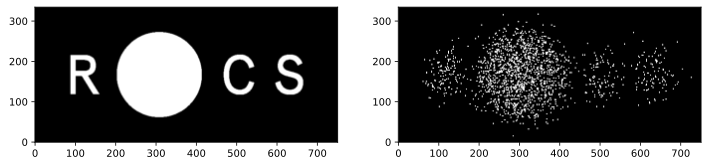

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(data, origin='lower', cmap=plt.get_cmap('gist_gray'))
ax[1].imshow(rocs_pic, origin='lower', vmax = 0.1, cmap=plt.get_cmap('gist_gray'));

----

### Exercise 3: Optically thick radiative transfer with scattering

In this exercise, you will go beyond LTE and calculate radiation with scattering from a solar model atmosphere. You will use the same FALC model that you used in previous projects. For simplicity, you will calculate radiation for a single wavelength. The outcome should be independent of wavelength, but since the FALC model already comes with an optical depth scale for 500 nm, it is easier to just assume a wavelength of 500 nm. 

In this exercise you will assume that $\varepsilon_\nu$ is constant throughout the atmosphere. This is not usually true: in a real atmosphere the photon destruction probability increases quickly as the density increases. You should also make use of a factor $\eta_\nu$, the ratio between the line optical depth and the continuum optical depth:

$$
\eta_\nu \equiv \frac{\tau_\nu^l}{\tau_\nu^c},
$$

so that the total optical depth can be written as:

$$
\tau_\nu^\mathrm{total} = \tau_\nu^c (1 + \eta_\nu).
$$

For $\tau_\nu^c$ use the variable `tau_500` from the FALC model.


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Write a simple lambda iteration solver that computes $J_\nu$ and $S_\nu$ for the single wavelength of 500 nm as a function of $\tau_\nu^c$, $B_\nu$, $\eta_\nu$, and $\varepsilon_\nu$. You can obtain $B_\nu$ by using the temperatures in a model atmosphere.
    
* Using your solver, compute $J_\nu$ and $S_\nu$ for the FALC model atmosphere. Run for $\varepsilon_\nu = [0.5, 10^{-2}, 10^{-3}]$, and $\eta_\nu= [10^2, 10^4, 10^6]$ and for each of the nine combinations plot $J_\nu$, $S_\nu$, and $B_\nu$ vs $\tau_\nu^c$. 
    
* Explain what is happening in physical terms. How does $\eta_\nu$ affect the result? And $\varepsilon_\nu$? When is LTE no longer valid? At what point is radiation thermalised ($J_\nu \approx B_\nu$)?
    
* Scattering makes radiation decouple from the local conditions deeper in the atmosphere that it would otherwise. So the photons that reach the surface are effectively formed in deeper layers. But scattering can greatly reduce the number of photons that reach the surface (e.g. see decrease in $J_\nu$). The more scattering, the fewer photons reaching the surface. Why is that? 
    
* Assuming $\varepsilon_\nu$ is constant with height helps understand scattering, but is a poor approximation. Compute and plot the height-dependent $\varepsilon_\nu$ for the FALC model at 500 nm, using the extinction sources you computed in Project 4 (H$^{-}$ extinction and Thomson scattering). At which height does scattering start to be important?
 
    
*Hints:*
* *The simple lambda iteration method struggles for $\varepsilon_\nu \ll 1$. Do not run for $\varepsilon_\nu < 10^{-3}$.*
* *You can check if your solution is physical by noting that in the interior of the star, TE holds, so $J_\nu = S_\nu = B_\nu$. If this stops being the case, you have some numerical errors.*
* *If you use the original FALC depth grid with 80 depth points, lambda iteration will start failing around $\varepsilon_\nu < 10^{-1}$. This can be mitigated by using a higher resolution optical depth grid, for example by interpolating the FALC values to a finer grid. The lower the $\varepsilon_\nu$, the more depth points you will need to avoid numerical errors.*
 
</div>